# Particle Filter Localization

## Timothy Devon Morris

### Particle Filters
Particle filters or Sequential Monte Carlo (SMC) methods are a set of genetic, Monte Carlo algorithms used to solve filtering problems arising in signal processing and Bayesian statistical inference. The filtering problem consists of estimating the internal states in dynamical systems when partial observations are made, and random perturbations are present in the sensors as well as in the dynamical system. The objective is to compute the posterior distributions of the states of some Markov process, given some noisy and partial observations. The term "particle filters" was first coined in 1996 by Del Moral in reference to mean field interacting particle methods used in fluid mechanics since the beginning of the 1960s. The terminology "sequential Monte Carlo" was proposed by Liu and Chen in 1998.

In [1]:
from __future__ import division
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
from IPython.display import display,HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc

### Robot Motion Class
Our 2D robot has a state vector consisting of $(x, y , \theta)^T$. We assume that our robot follows a nonlinear dynamics model implemented with a velocity controller on $v$ and $\omega$. Together $(v,\omega)^T = u$. Thus,
$\mathbf{x}_t = f(\mathbf{x}_{t-1},u)$
where

$$f(\mathbf{x}_{t-1},u) = 
\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\theta_{t-1}
\end{bmatrix} + 
\begin{bmatrix}
-\frac{v}{\omega}\sin{\theta_{t-1}} + \frac{v}{\omega}\sin{(\theta_{t-1} + \omega \Delta t)} \\
\frac{v}{\omega}\cos{\theta_{t-1}} - \frac{v}{\omega}\cos{(\theta_{t-1} + \omega \Delta t)} \\
\omega \Delta t
\end{bmatrix}$$

We assume that with our control input $u$ we have associated noise 

$$
\begin{bmatrix}
\hat{v} \\
\hat{\omega}
\end{bmatrix} =
\begin{bmatrix}
v \\
\omega
\end{bmatrix}
+ 
\begin{bmatrix}
\varepsilon_{\alpha_1 v^2 + \alpha_2 \omega^2} \\
\varepsilon_{\alpha_3 v^2 + \alpha_4 \omega^2}
\end{bmatrix}$$

where $\varepsilon_{b^2} \sim \mathcal{N}(0,b^2)$

Note: the velocity motion model doesn't work for straight line motion, this is because we divide by $\omega$.



In [2]:
class VCRobot(object):
    '''
    Class to implement a velocity controlled two-wheeled robot
    
    The robot has state (x, y, theta) 
    The motion model is described in Probabilistic Robotics by Thrun ch. 5d
    '''
    def __init__(self, dt, alpha):
        '''
        member variables:
        dt - time step
        alpha - numpy array (4) describing noise characteristics
        '''
        self.dt = dt
        self.alpha = alpha
    
    def generate_motion(self,v,w,x0):
        '''
        inputs:
        v - numpy array (T) describing velocity
        w - numpy array (T) describing angular velocity
        x0 - numpy array (3) describing initial position
        
        outputs:
        X - numpy array (T,3) describing state at each time step
        '''
        dt = self.dt
        alpha = self.alpha
        T = len(v)
        
        X = np.zeros((T+1,3))
        X[0,:] = x0
        
        for t in xrange(T):
            var1 = alpha[0]*v[t]**2 + alpha[1]*w[t]**2
            var2 = alpha[2]*v[t]**2 + alpha[3]*w[t]**2
            v_hat = v[t] + np.sqrt(var1)*np.random.randn()
            w_hat = w[t] + np.sqrt(var2)*np.random.randn()
            stheta = np.sin(X[t,2])
            ctheta = np.cos(X[t,2])
            sthetap = np.sin(X[t,2] + dt*w_hat)
            cthetap = np.cos(X[t,2] + dt*w_hat)
            
            X[t+1,0] = X[t,0] - v_hat/w_hat*stheta + v_hat/w_hat*sthetap
            X[t+1,1] = X[t,1] + v_hat/w_hat*ctheta - v_hat/w_hat*cthetap
            X[t+1,2] = X[t,2] + w_hat*dt
        
        return X
        
class LocalizationAnimation(object):
    '''
    Class to visualize the 2D localization problem for a two-wheeled robot
    
    The robot has state (x, y, theta)
    The motion model is described in Probabilistic Robotics by Thrun ch. 5d
    '''
    def __init__(self, X, Y,dt):
        '''
        member variables:
        X - numpy array (T,3) state of the robot
        Y - numpy array (m,2) Locations of landmarks
        '''
        self.X = X
        self.Y = Y
        self.dt = dt
    
    def animate(self):
        '''
        X - numpy array (3,T) describing state at each time step
        '''
        X = self.X
        Y = self.Y
        dt = self.dt
        T = X.shape[0]
        
        xm = -20
        xM = 20
        ym = -20
        yM = 20
        
        env = plt.figure(figsize=(8, 8))
        ax = env.add_subplot(1, 1, 1)
        ax.set_xlim((xm, xM))
        ax.set_ylim((ym, yM))
        ax.set_title("Robot Environment",fontsize=20)
        ax.set_xlabel("X position (m)", fontsize=16)
        ax.set_ylabel("Y position (m)", fontsize=16)
        
        robot = plt.Circle((X[0, 0], X[0, 1]), 1, fill=False)
        ax.add_artist(robot)
        direction = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        line, = ax.plot(X[0, 0] + direction[0, :], X[1, 0] + direction[1, :], 'k')
        features, = ax.plot(Y[:, 0], Y[:, 1], 'gD')

        def animate(i):
            direction = np.array([[0, np.cos(X[i, 2])], [0, np.sin(X[i, 2])]])
            line.set_data(X[i, 0] + direction[0, :], X[i, 1] + direction[1, :])
            robot.center = X[i, 0], X[i, 1]
            return (line,)
        
        anim = animation.FuncAnimation(env, animate, frames=T, interval=dt*500, blit=True)
        return anim

In [3]:
dt = .1
alpha = np.array([.1, .01, .01, .1])
t = np.arange(0,20.1, dt)
x0 = np.array([-5, -3, np.pi/2])
Y = np.array([[6., 4.],
              [-7., 8.],
              [6., -4]])
R = np.array([[.01, .0],
              [0., .0025]])

v = 1 + .5*np.cos(.4*np.pi*t)
w = -.2 + 2*np.cos(1.2*np.pi*t)
robot = VCRobot(dt, alpha)
X = robot.generate_motion(v,w,x0)
ani = LocalizationAnimation(X,Y,dt)
HTML(ani.animate().to_html5_video())

### Landmarks
As seen in the plot above, we assume there are a number of stationary landmarks from which the robot can take range and bearing measurements. Since these landmarks have fixed position, we can use these measurements to determine our location and bearing. For each landmark $m$ we have an associated $\mathbf{x}_m = (x_m, y_m)^T$ denoting it's position. Since range is a norm and the bearing uses arctangent, this measurement model is inherently nonlinear. We denote this by
$\mathbf{z}_{t,m} = h(\mathbf{x}_{t}, \mathbf{x}_{m}, u)$.
Explicitly,

$$h(\mathbf{x}_t, \mathbf{x}_m, u) = 
\begin{bmatrix}
\sqrt{(x_m - x_t)^2 + (y_m - y_t)^2} \\
\arctan2{\frac{y_m - y_t}{x_m - x_t}}
\end{bmatrix}
$$

Note: In this case and many others, our measurement model does not directly depend on our control input $u$.

In [4]:
class LandmarkSensor(object):
    '''
    Class to simulate a landmark sensor
    This is a basic range-bearing sensor in 2D
    '''
    
    def __init__(self, Y, R):
        '''
        member variables:
        Y - numpy array (m, 2) locations of the landmarks
        R - noise covariance associated with range and bearing
        '''
        self.Y = Y
        self.R = R
        
    def simulate(self, X):
        '''
        inputs:
        X - numpy array (T,3) of vehicle state (x,y, theta)
        
        outputs:
        Z - numpy array (T,2*m) of range/bearing measurements
        '''
        Y = self.Y
        m, _ = Y.shape
        T, _ = X.shape
        
        Z = np.zeros((T,2*m))
        
        for i in xrange(m):
            Z[:, 2*i] = np.linalg.norm(X[:, 0:2] - self.Y[i,:], axis=1)
            Z[:, 2*i+1] = np.arctan2(self.Y[i,1] - X[:,1], self.Y[i,0] - X[:,0]) - X[:,2]
            
        for t in xrange(T):
            for i in xrange(m):
                Z[t, 2*i:2*i+2] += np.random.multivariate_normal(np.zeros(2), self.R)  
        return Z

In [5]:
rbsensor = LandmarkSensor(Y,R)
Z = rbsensor.simulate(X[1:,:])

### Particle Filter Class
Particle filters implement the prediction-updating transitions of the filtering equation directly by using a genetic type mutation-selection particle algorithm. The samples from the distribution are represented by a set of particles; each particle has a likelihood weight assigned to it that represents the probability of that particle being sampled from the probability density function



In [6]:
class PF(object):
    '''
    Class to implement a particle filter for the locatlization problem
    '''
    
    def __init__(self, f, g, Q, R, num_particles=5000):
        '''
        Class Variables:
        f(x,u) - function handle nonlinear state transition
        h(x,y,u) - function handle nonlinear measurement model
        Q(u) - function handle Covariance of input
        R - numpy matrix (mxm) sensor noise covariance
        '''
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R
        self.num_particles = num_particles
        
    def filter(self, Z, U, Y, x_b, anim=True):
        '''
        Filters over a fixed number of time steps
        
        Inputs:
        Z - numpy matrix (Txm) measurements for T time steps
        U - numpy matrix (Txk) controls for T time steps
        Y - numpy matrix (Txl)
        x_b - numpy matrix (nx2) of min, max for states
        
        Outputs:
        X - numpy matrix (Txn) 
        '''
        n,_ = x_b.shape
        T,m = Z.shape
        T,k = U.shape
        
        Chi = np.zeros((n, self.num_particles))
        Chi_t = np.zeros((2*T+1, n, self.num_particles))
        X_hat = np.zeros((T,n))
        C = np.zeros((T,n))
        
        for i in xrange(n):
            Chi[i] = np.random.uniform(low=x_b[i,0], high=x_b[i,1], size=self.num_particles)
        Chi_t[0] = np.copy(Chi)
        
        
        for t,u in enumerate(U):
            Q = self.Q(u)
            
            # prediction
            u_n = u[:, np.newaxis] + np.random.multivariate_normal(mean=np.zeros(k),cov=Q, size=self.num_particles).T
            Chi = f(Chi,u_n)
            Chi_t[2*t+1] = np.copy(Chi)
                
            # measurement
            W = np.ones(self.num_particles)
            for m,y in enumerate(Y):
                y = np.atleast_2d(y).T
                v = (self.h(Chi,y,u)-Z[t,2*m:2*m+2, np.newaxis])
                v = np.sum(-.5*v*(la.inv(R)).dot(v), axis=0)
                v = v - np.max(v)
                w = np.exp(v)/np.sum(np.exp(v))
                W *= w
                
            # resample
            W = W/np.sum(W)
            idx = np.random.choice(np.arange(self.num_particles), 
                                             size=self.num_particles, p=W)
            Chi = Chi[:,idx]
            Chi_t[2*t+2] = np.copy(Chi)
            X_hat[t] = np.mean(Chi, axis=1)
            C[t] = np.var(Chi, axis=1)
        
        return X_hat, C, Chi_t   
    
class PFAnimation(object):
    '''
    Class to visualize the 2D localization problem for a two-wheeled robot
    
    The robot has state (x, y, theta)
    The motion model is described in Probabilistic Robotics by Thrun ch. 5d
    '''
    def __init__(self, X, Y, Chi, dt):
        '''
        member variables:
        X - numpy array (T,3) state of the robot
        Y - numpy array (m,2) Locations of landmarks
        '''
        self.X = X
        self.Y = Y
        self.Chi = Chi
        self.dt = dt
    
    def animate(self):
        '''
        X - numpy array (3,T) describing state at each time step
        '''
        X = self.X
        Y = self.Y
        Chi = self.Chi
        dt = self.dt
        T = X.shape[0]
        
        xm = -20
        xM = 20
        ym = -20
        yM = 20
        
        env = plt.figure(figsize=(8, 8))
        ax = env.add_subplot(1, 1, 1)
        ax.set_xlim((xm, xM))
        ax.set_ylim((ym, yM))
        ax.set_title("Robot Environment",fontsize=20)
        ax.set_xlabel("X position (m)", fontsize=16)
        ax.set_ylabel("Y position (m)", fontsize=16)
        
        robot = plt.Circle((X[0, 0], X[0, 1]), 1, fill=False)
        ax.add_artist(robot)
        direction = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        line, = ax.plot(X[0, 0] + direction[0, :], X[1, 0] + direction[1, :], 'k')
        features, = ax.plot(Y[:, 0], Y[:, 1], 'gD')
        particles = ax.scatter(Chi[0, 0, :], Chi[0, 1, :],s=.1)

        def animate(i):
            direction = np.array([[0, np.cos(X[i//2, 2])], [0, np.sin(X[i//2, 2])]])
            line.set_data(X[i//2, 0] + direction[0, :], X[i//2, 1] + direction[1, :])
            particles.set_offsets(np.column_stack((Chi[i,0,:], Chi[i,1,:])))
            robot.center = X[i//2, 0], X[i//2, 1]
            return (line,)
        
        anim = animation.FuncAnimation(env, animate, frames=2*T-1, interval=dt*250, blit=True)
        return anim

In [7]:
def f(x,u):
    xp = np.array(np.zeros_like(x))
    v = u[0]
    w = u[1]
    stheta = np.sin(x[2])
    ctheta = np.cos(x[2])
    sthetap = np.sin(x[2] + dt*w)
    cthetap = np.cos(x[2] + dt*w)

    xp[0] = x[0] - v/w*stheta + v/w*sthetap
    xp[1] = x[1] + v/w*ctheta - v/w*cthetap
    xp[2] = x[2] + w*dt
    return xp

def h(x,y,u):
    _, n = x.shape
    m, _ = y.shape
    zp = np.zeros((m,n))
    
    zp[0] = np.linalg.norm(x[0:2] - y, axis=0)
    zp[1] = np.arctan2(y[1] - x[1], y[0] - x[0]) - x[2]
    return zp 

def Qt(u):
    k = u.shape[0]
    v = u[0]
    w = u[1]
    Q = np.matrix(np.zeros((k,k)))
    Q[0,0] = alpha[0]*v**2 + alpha[1]*w**2
    Q[1,1] = alpha[2]*v**2 + alpha[3]*w**2
    return Q

U = np.column_stack([v, w])
x_b = np.array([[-20,20],
                [-20,20],
                [4*np.pi/6,2*np.pi/6]])

pf = PF(f,h,Qt,R)

In [8]:
X_hat, C, Chi_t = pf.filter(Z, U, Y, x_b)
ani = PFAnimation(X,Y, Chi_t,dt)
HTML(ani.animate().to_html5_video())

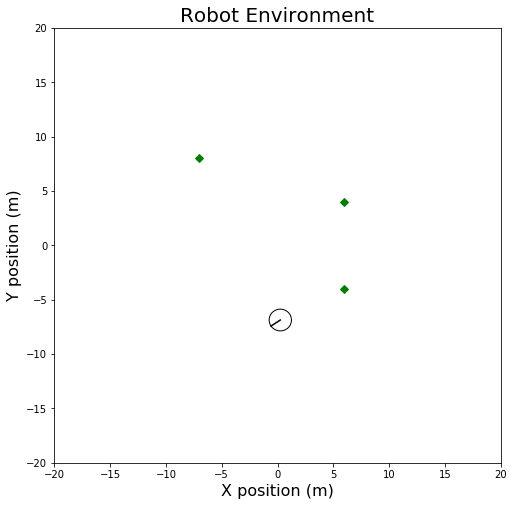

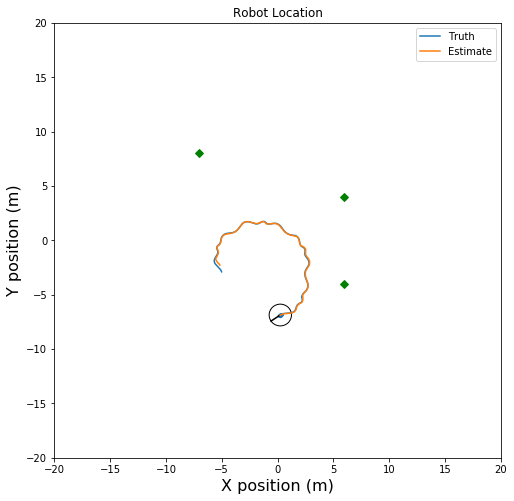

In [9]:
plt.plot(X[1:,0],X[1:,1],label="Truth")
plt.plot(X_hat[:,0], X_hat[:,1],label="Estimate")
plt.title("Robot Location")
plt.legend()
plt.show()

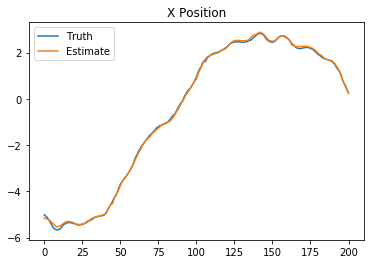

In [10]:
plt.plot(X[1:,0],label="Truth")
plt.plot(X_hat[:,0],label="Estimate")
plt.title("X Position")
plt.legend()
plt.show()

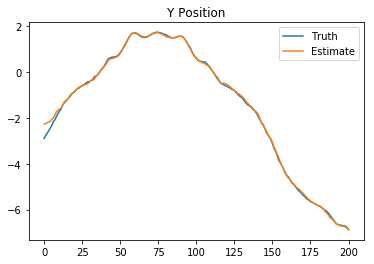

In [11]:
plt.plot(X[1:,1],label="Truth")
plt.plot(X_hat[:,1],label="Estimate")
plt.title("Y Position")
plt.legend()
plt.show()

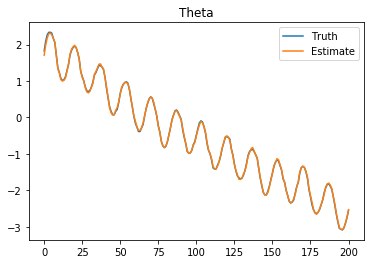

In [12]:
plt.plot(X[1:,2],label="Truth")
plt.plot(X_hat[:,2],label="Estimate")
plt.title("Theta")
plt.legend()
plt.show()

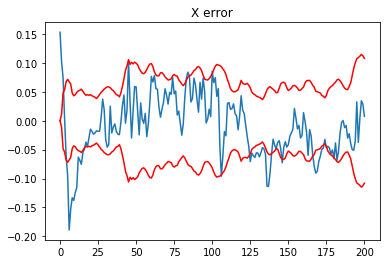

In [13]:
plt.plot(X[1:,0]-X_hat[:,0])
plt.plot(2*np.sqrt(C[:,0]), color='r')
plt.plot(- 2*np.sqrt(C[:,0]), color='r')
plt.title("X error")
plt.show()

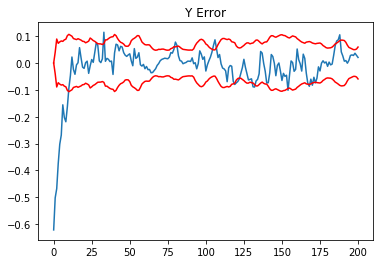

In [14]:
plt.plot(X[1:,1]-X_hat[:,1])
plt.plot(2*np.sqrt(C[:,1]), color='r')
plt.plot(- 2*np.sqrt(C[:,1]), color='r')
plt.title("Y Error")
plt.show()

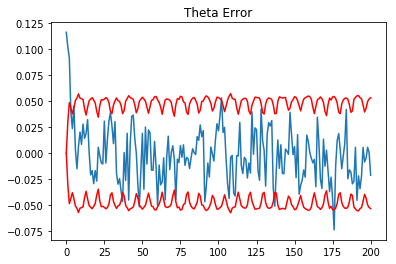

In [15]:
plt.plot(X[1:,2]-X_hat[:,2])
plt.plot(2*np.sqrt(C[:,2]), color='r')
plt.plot(- 2*np.sqrt(C[:,2]), color='r')
plt.title("Theta Error")
plt.show()